# Initialization

## Download Data from the web

In [91]:
# Download the data from Kaggle and unzip it
import opendatasets as od
datasetURL = "https://www.kaggle.com/datasets/gpiosenka/100-bird-species/data"
od.download(datasetURL)


Skipping, found downloaded files in "./100-bird-species" (use force=True to force download)


## Library Import

In [92]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ExifTags
from tqdm.notebook import tqdm
import cv2
from scipy.stats import skew, kurtosis
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [93]:
# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")
sns.set_palette("deep")

## Data Loading

In [94]:
def load_image_data(data_dir):
    image_data = []
    for split in ['train', 'test', 'valid']:
        split_dir = os.path.join(data_dir, split)
        for species in os.listdir(split_dir):
            species_dir = os.path.join(split_dir, species)
            for img_file in os.listdir(species_dir):
                image_data.append({
                    'split': split,
                    'species': species,
                    'file_path': os.path.join(species_dir, img_file)
                })
    return pd.DataFrame(image_data)

data_dir = './100-bird-species'  # Replace with your actual data directory
df = load_image_data(data_dir)
df

split                   species  \
0      train  CREAM COLORED WOODPECKER   
1      train  CREAM COLORED WOODPECKER   
2      train  CREAM COLORED WOODPECKER   
3      train  CREAM COLORED WOODPECKER   
4      train  CREAM COLORED WOODPECKER   
...      ...                       ...   
89880  valid           GILA WOODPECKER   
89881  valid           GILA WOODPECKER   
89882  valid           GILA WOODPECKER   
89883  valid           GILA WOODPECKER   
89884  valid           GILA WOODPECKER   

                                               file_path  
0      ./100-bird-species/train/CREAM COLORED WOODPEC...  
1      ./100-bird-species/train/CREAM COLORED WOODPEC...  
2      ./100-bird-species/train/CREAM COLORED WOODPEC...  
3      ./100-bird-species/train/CREAM COLORED WOODPEC...  
4      ./100-bird-species/train/CREAM COLORED WOODPEC...  
...                                                  ...  
89880     ./100-bird-species/valid/GILA WOODPECKER/4.jpg  
89881     ./100-bird-species/valid/GILA WOODPECKER/5.jpg  
89882     ./100-bird-species/valid/GILA WOODPECKER/2.jpg  
89883     ./100-bird-species/valid/GILA WOODPECKER/3.jpg  
89884     ./100-bird-species/valid/GILA WOODPECKER/1.jpg  

[89885 rows x 3 columns]

# Exploratory Data Analysis (EDA)

In [95]:
# Basic dataset information
print("Dataset Overview:")
print(f"Total number of images: {len(df)}")
print(f"Number of classes: {df['species'].nunique()}")
print("\nClass distribution:")
print(df['species'].value_counts())

Dataset Overview:
Total number of images: 89885
Number of classes: 526

Class distribution:
species
RUFOUS TREPE               273
HOUSE FINCH                258
OVENBIRD                   243
D-ARNAUDS BARBET           243
ASIAN GREEN BEE EATER      230
                          ... 
RED TAILED THRUSH          140
NORTHERN RED BISHOP        140
PATAGONIAN SIERRA FINCH    140
SNOWY PLOVER               140
PARAKETT AUKLET              5
Name: count, Length: 526, dtype: int64


## 1. Class Distribution

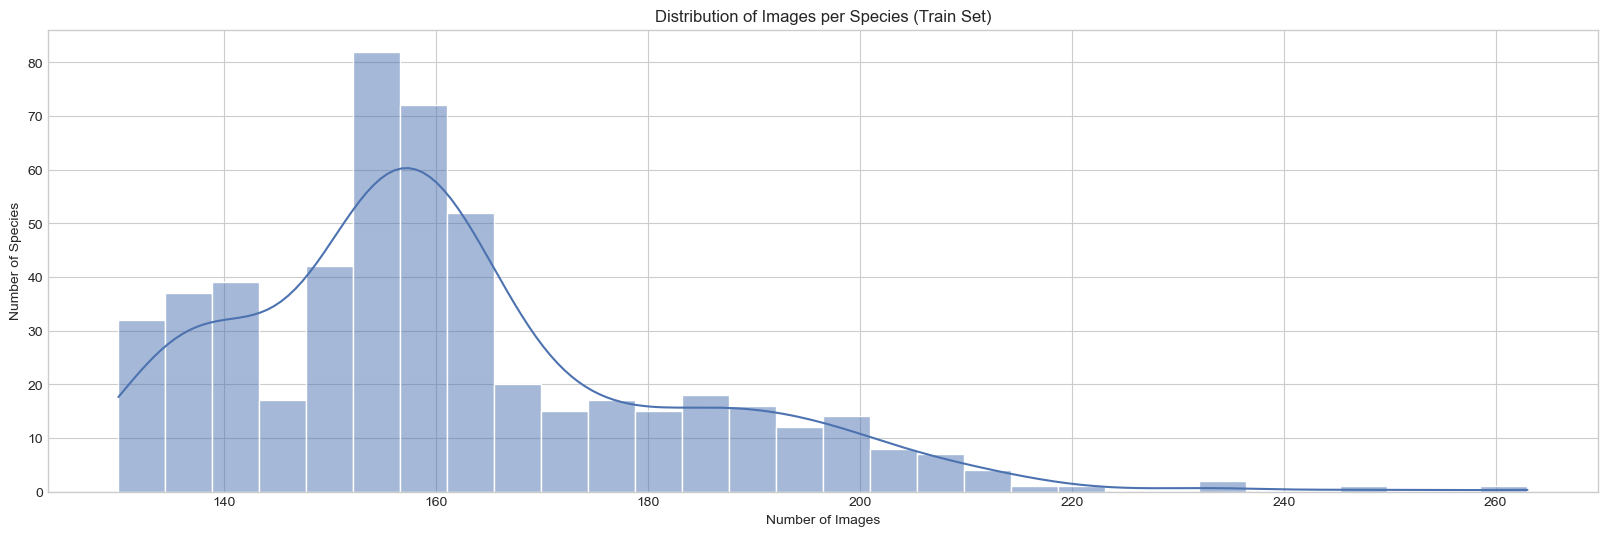

Statistics for Train Set:
Mean images per class: 161.21
Median images per class: 158.00
Min images per class: 130
Max images per class: 263




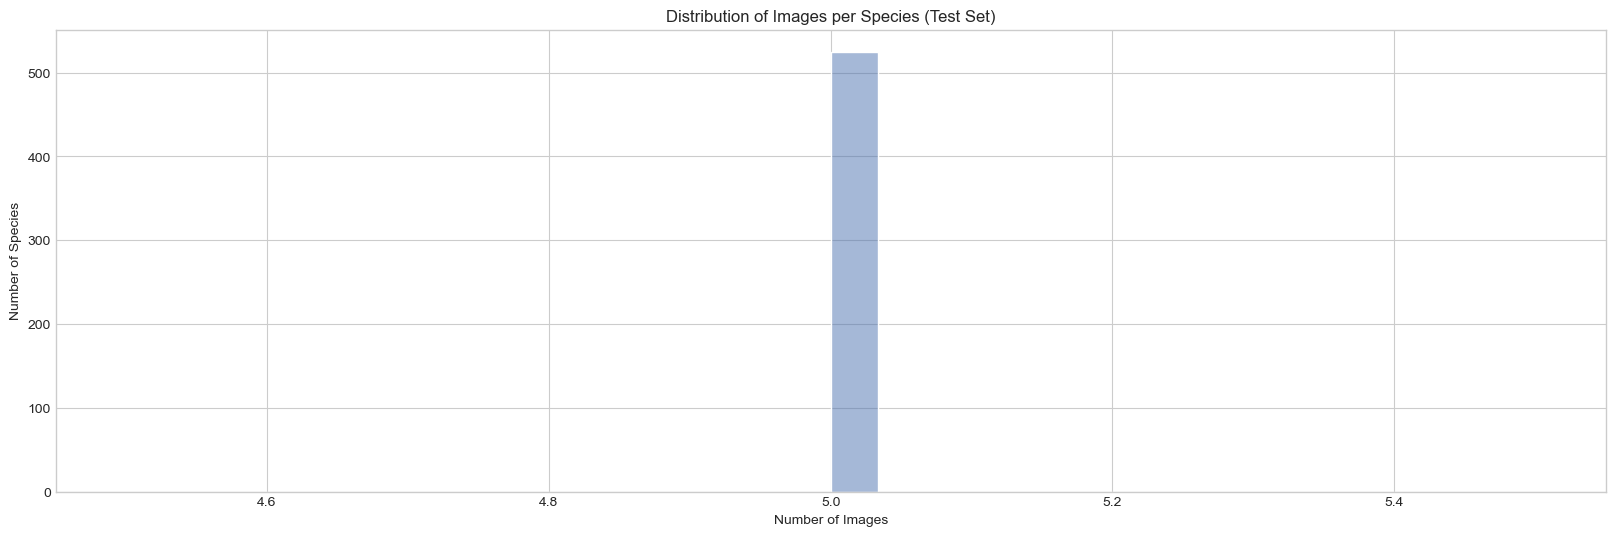

Statistics for Test Set:
Mean images per class: 5.00
Median images per class: 5.00
Min images per class: 5
Max images per class: 5




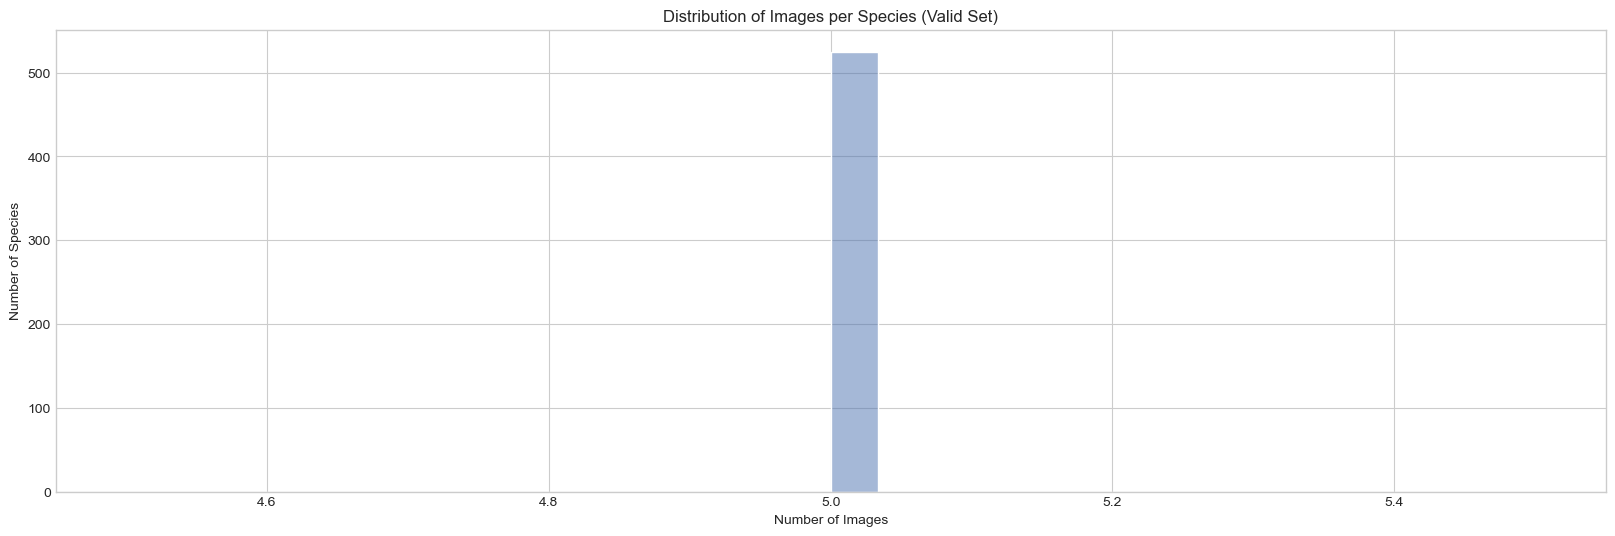

Statistics for Valid Set:
Mean images per class: 5.00
Median images per class: 5.00
Min images per class: 5
Max images per class: 5




In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot distribution and statistics for a given split
def plot_class_distribution(split_name):
    class_dist = df[df['split'] == split_name]['species'].value_counts()
    
    plt.figure(figsize=(20, 6))
    sns.histplot(class_dist, kde=True, bins=30)
    plt.title(f'Distribution of Images per Species ({split_name.capitalize()} Set)')
    plt.xlabel('Number of Images')
    plt.ylabel('Number of Species')
    plt.show()
    
    print(f"Statistics for {split_name.capitalize()} Set:")
    print(f"Mean images per class: {class_dist.mean():.2f}")
    print(f"Median images per class: {class_dist.median():.2f}")
    print(f"Min images per class: {class_dist.min()}")
    print(f"Max images per class: {class_dist.max()}")
    print("\n")

# Plot for each split
for split in ['train', 'test', 'valid']:
    plot_class_distribution(split)

## 2. Image Quality Assessment

Corrupt or unreadable images: 0


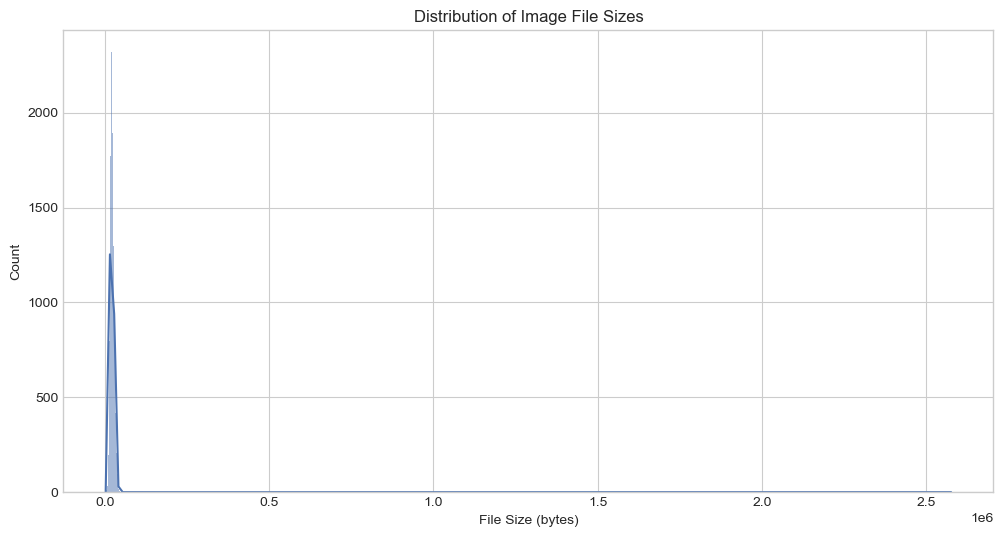

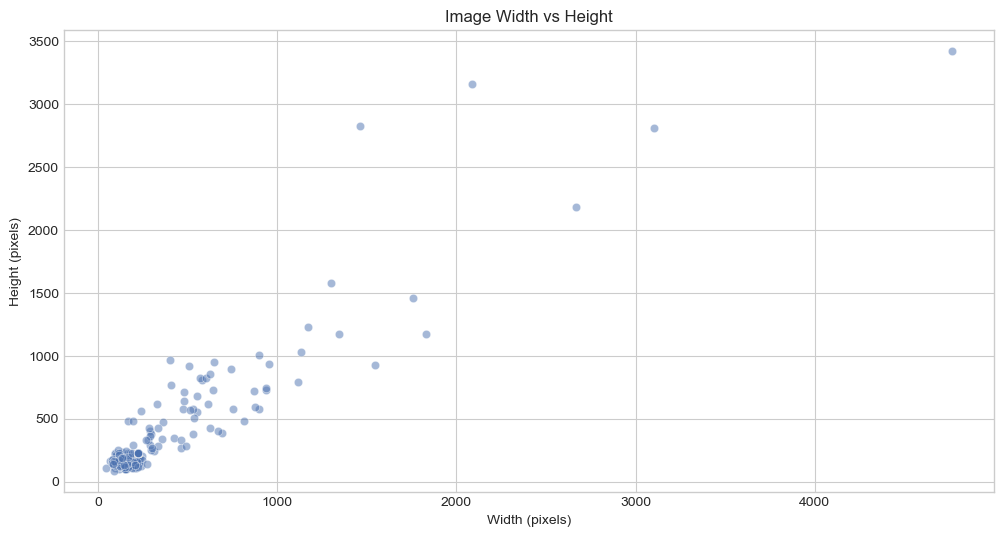

In [97]:
def assess_image_quality(file_path):
    try:
        with Image.open(file_path) as img:
            size = os.path.getsize(file_path)
            width, height = img.size
            channels = len(img.getbands())
            return {'readable': True, 'size': size, 'width': width, 'height': height, 'channels': channels}
    except Exception as e:
        return {'readable': False, 'error': str(e)}

quality_data = df['file_path'].apply(assess_image_quality)
df = pd.concat([df, pd.DataFrame(quality_data.tolist())], axis=1)

# Print the count of corrupt or unreadable images
print(f"Corrupt or unreadable images: {(~df['readable']).sum()}")

plt.figure(figsize=(12, 6))
sns.histplot(df['size'], kde=True)
plt.title('Distribution of Image File Sizes')
plt.xlabel('File Size (bytes)')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='width', y='height', data=df, alpha=0.5)
plt.title('Image Width vs Height')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True)
plt.show()

## 3. Color Distribution Analysis

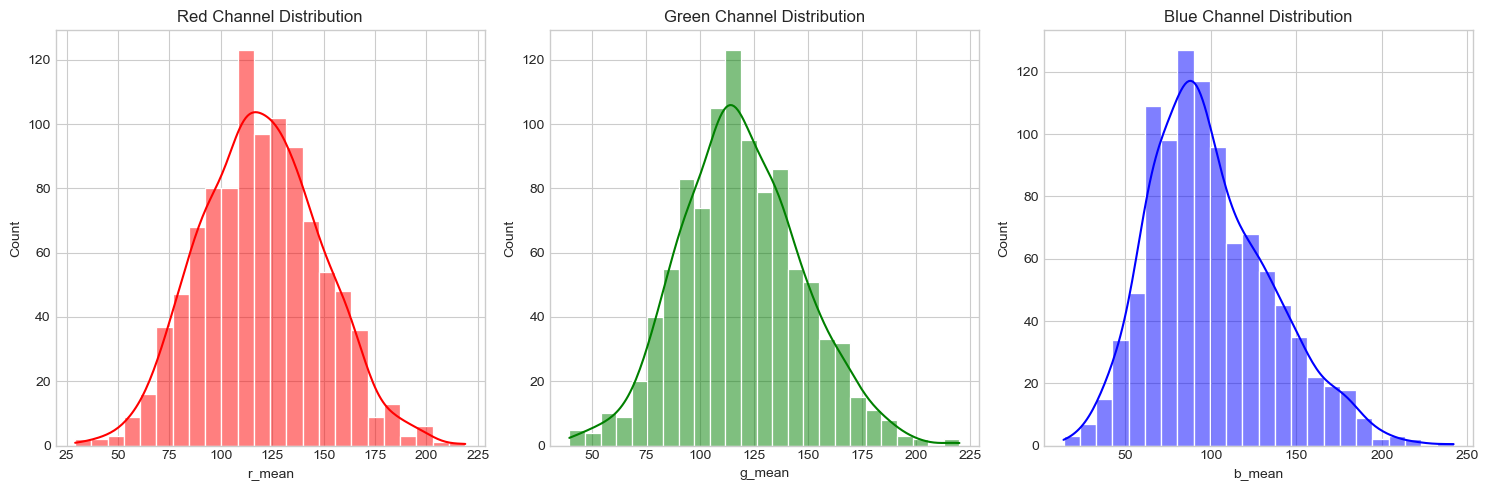

Grayscale images: 0


In [98]:
def analyze_color_distribution(file_path):
    img = np.array(Image.open(file_path))
    if len(img.shape) == 2:  # Grayscale
        return {'r_mean': img.mean(), 'g_mean': img.mean(), 'b_mean': img.mean(), 'is_grayscale': True}
    else:  # Color
        return {
            'r_mean': img[:,:,0].mean(),
            'g_mean': img[:,:,1].mean(),
            'b_mean': img[:,:,2].mean(),
            'is_grayscale': False
        }

sample_size = 1000
color_data = df.sample(sample_size)['file_path'].apply(analyze_color_distribution)
color_df = pd.DataFrame(color_data.tolist())

plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.histplot(color_df['r_mean'], color='r', kde=True)
plt.title('Red Channel Distribution')
plt.subplot(132)
sns.histplot(color_df['g_mean'], color='g', kde=True)
plt.title('Green Channel Distribution')
plt.subplot(133)
sns.histplot(color_df['b_mean'], color='b', kde=True)
plt.title('Blue Channel Distribution')
plt.tight_layout()
plt.show()

print(f"Grayscale images: {color_df['is_grayscale'].sum()}")

### 4. Sample Visualizationm

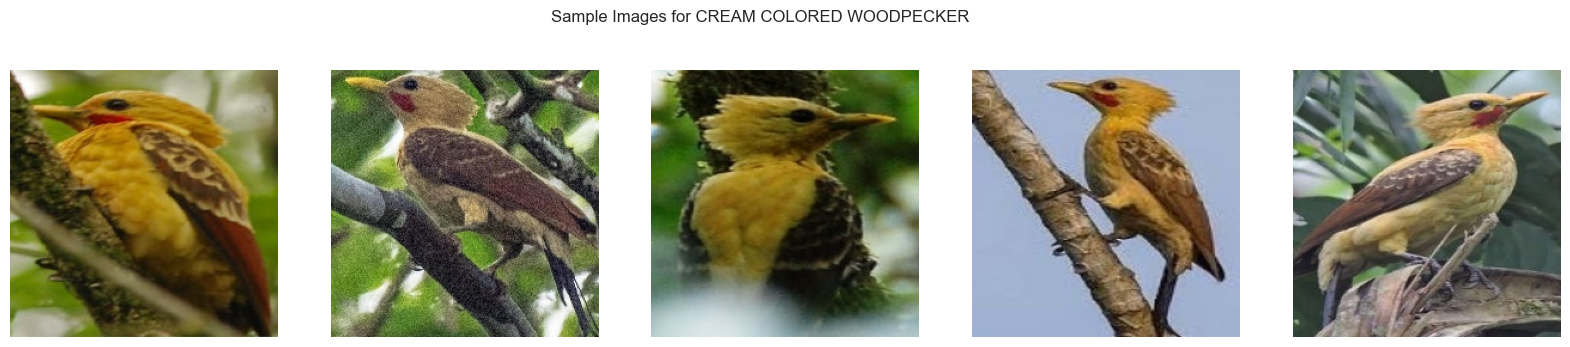

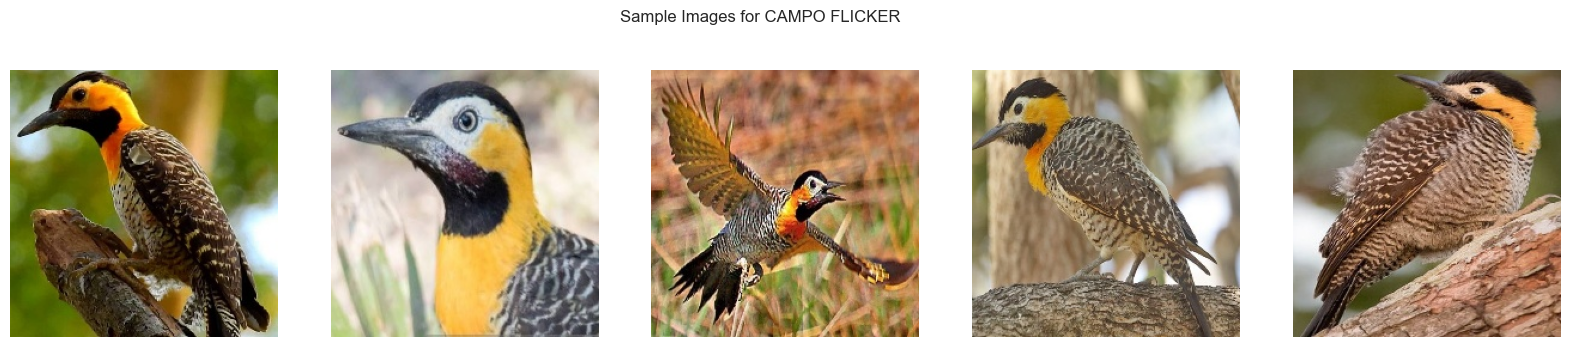

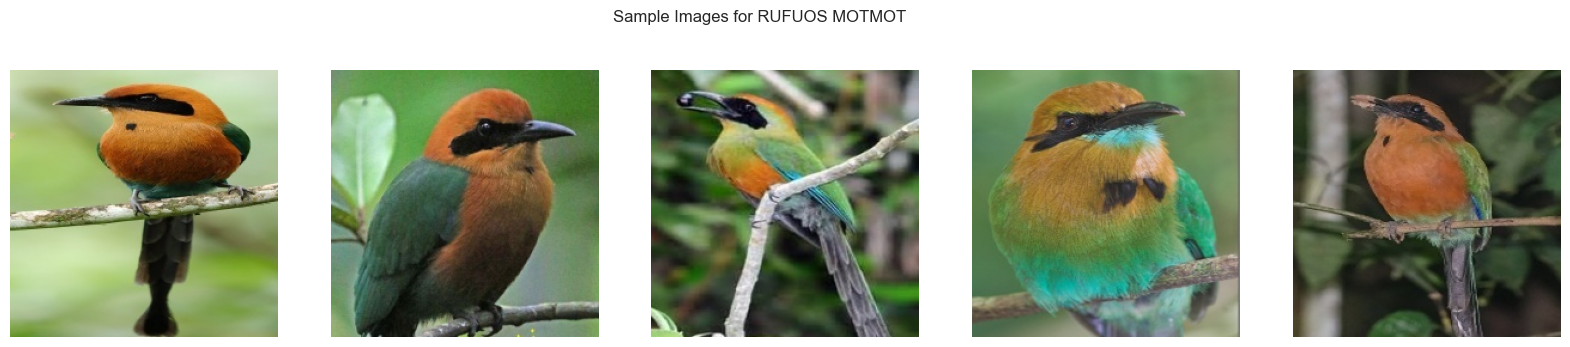

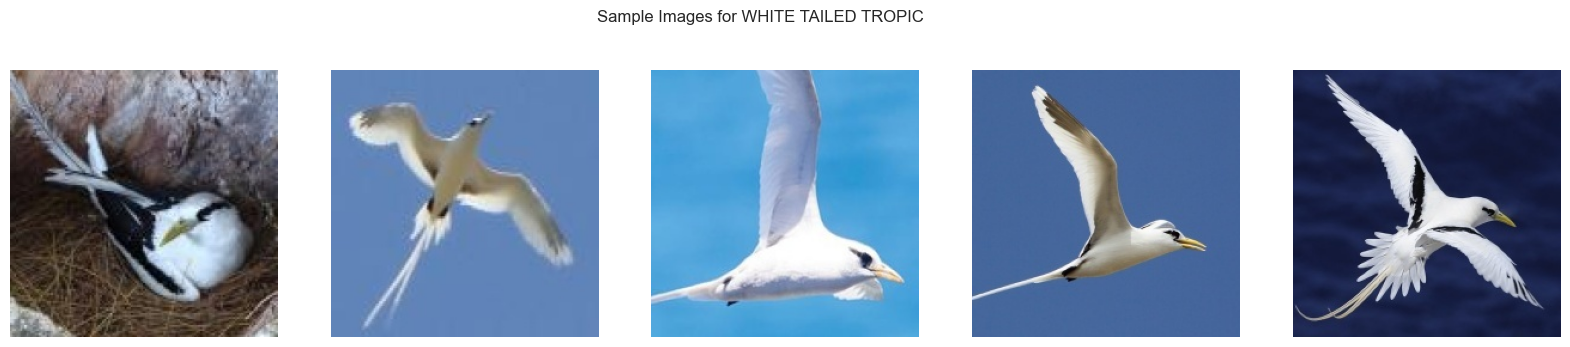

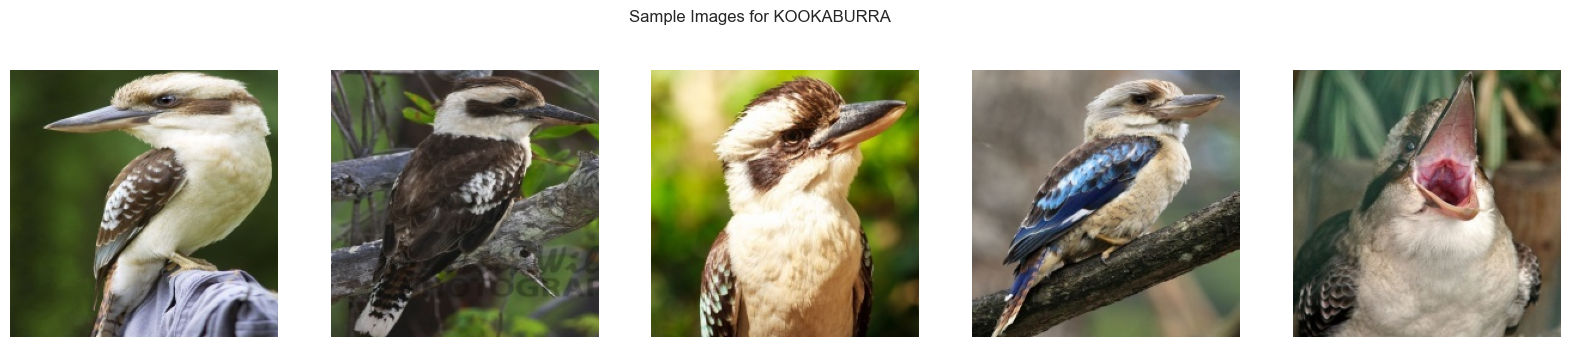

In [99]:
def plot_sample_images(species, num_samples=5):
    sample_paths = df[df['species'] == species].sample(num_samples)['file_path']
    
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    for ax, img_path in zip(axes, sample_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(f'Sample Images for {species}')
    plt.show()

# Plot samples for a few species
for species in df['species'].unique()[:5]:  # First 5 species
    plot_sample_images(species)

### 5. Background Analysis

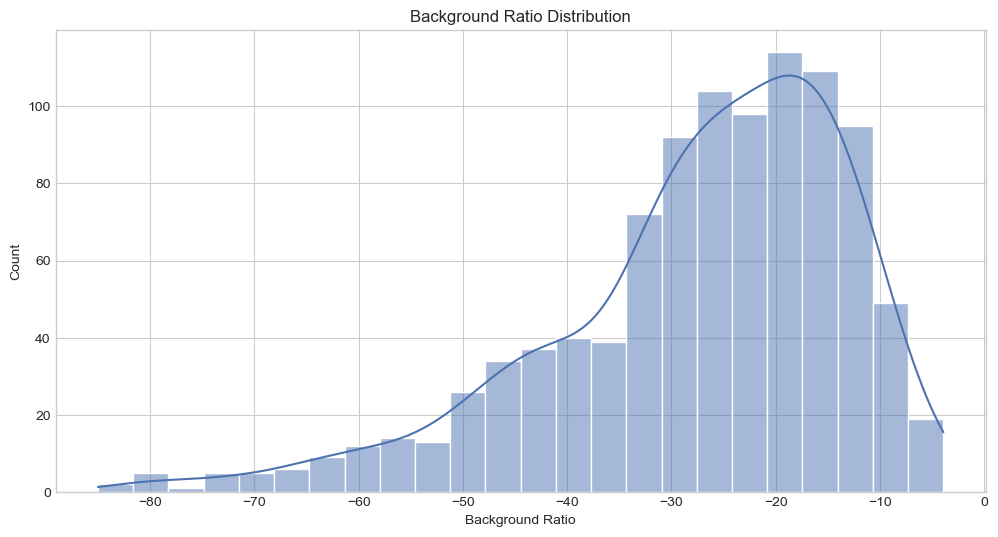

In [100]:
def analyze_background(file_path):
    img = cv2.imread(file_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    background_ratio = 1 - (np.sum(edges) / (img.shape[0] * img.shape[1]))
    return background_ratio

background_data = df.sample(sample_size)['file_path'].apply(analyze_background)

plt.figure(figsize=(12, 6))
sns.histplot(background_data, kde=True)
plt.title('Background Ratio Distribution')
plt.xlabel('Background Ratio')
plt.show()

### 6. Bird Size Analysis

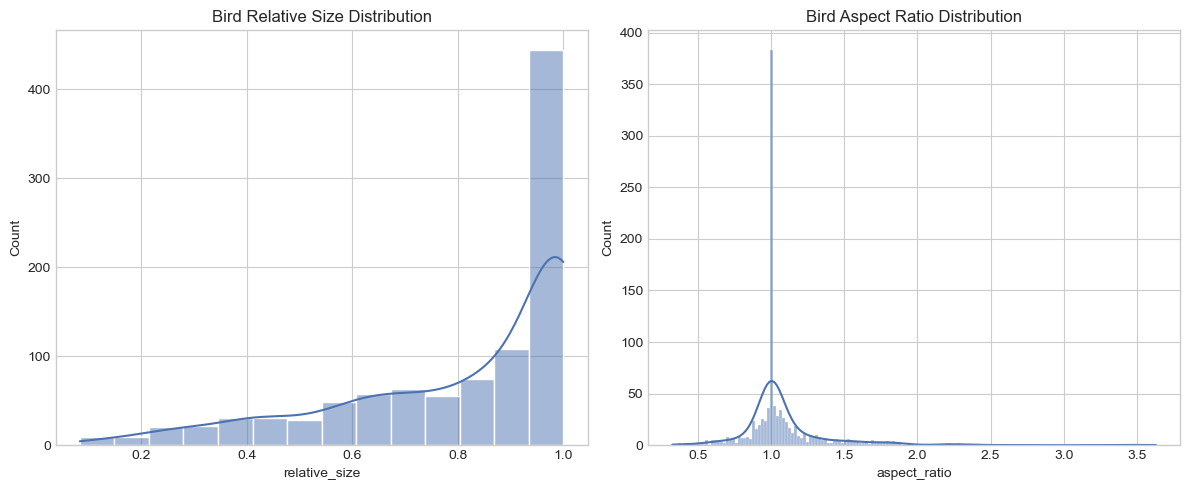

In [101]:
def analyze_bird_size(file_path):
    img = cv2.imread(file_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        relative_size = (w * h) / (img.shape[0] * img.shape[1])
        aspect_ratio = w / h
        return {'relative_size': relative_size, 'aspect_ratio': aspect_ratio}
    return {'relative_size': 0, 'aspect_ratio': 1}

bird_data = df.sample(sample_size)['file_path'].apply(analyze_bird_size)
bird_df = pd.DataFrame(bird_data.tolist())

plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.histplot(bird_df['relative_size'], kde=True)
plt.title('Bird Relative Size Distribution')
plt.subplot(122)
sns.histplot(bird_df['aspect_ratio'], kde=True)
plt.title('Bird Aspect Ratio Distribution')
plt.tight_layout()
plt.show()

In [102]:
# Summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
               size         width        height  channels
count  8.988500e+04  89885.000000  89885.000000   89885.0
mean   2.258133e+04    224.294276    224.329132       3.0
std    1.272733e+04     25.794144     24.296881       0.0
min    2.909000e+03     45.000000     83.000000       3.0
25%    1.846100e+04    224.000000    224.000000       3.0
50%    2.184900e+04    224.000000    224.000000       3.0
75%    2.594300e+04    224.000000    224.000000       3.0
max    2.575172e+06   4763.000000   3421.000000       3.0


In [103]:
df

split                   species  \
0      train  CREAM COLORED WOODPECKER   
1      train  CREAM COLORED WOODPECKER   
2      train  CREAM COLORED WOODPECKER   
3      train  CREAM COLORED WOODPECKER   
4      train  CREAM COLORED WOODPECKER   
...      ...                       ...   
89880  valid           GILA WOODPECKER   
89881  valid           GILA WOODPECKER   
89882  valid           GILA WOODPECKER   
89883  valid           GILA WOODPECKER   
89884  valid           GILA WOODPECKER   

                                               file_path  readable   size  \
0      ./100-bird-species/train/CREAM COLORED WOODPEC...      True  21526   
1      ./100-bird-species/train/CREAM COLORED WOODPEC...      True  25777   
2      ./100-bird-species/train/CREAM COLORED WOODPEC...      True  34935   
3      ./100-bird-species/train/CREAM COLORED WOODPEC...      True  29610   
4      ./100-bird-species/train/CREAM COLORED WOODPEC...      True  28112   
...                                                  ...       ...    ...   
89880     ./100-bird-species/valid/GILA WOODPECKER/4.jpg      True  30369   
89881     ./100-bird-species/valid/GILA WOODPECKER/5.jpg      True  25339   
89882     ./100-bird-species/valid/GILA WOODPECKER/2.jpg      True  23913   
89883     ./100-bird-species/valid/GILA WOODPECKER/3.jpg      True  21260   
89884     ./100-bird-species/valid/GILA WOODPECKER/1.jpg      True  24337   

       width  height  channels  
0        224     224         3  
1        224     224         3  
2        224     224         3  
3        224     224         3  
4        224     224         3  
...      ...     ...       ...  
89880    224     224         3  
89881    224     224         3  
89882    224     224         3  
89883    224     224         3  
89884    224     224         3  

[89885 rows x 8 columns]